In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from scipy import stats
%matplotlib inline

# Initialisation
## Données

In [2]:
seuil_detection_fitness=0.005

def analyse_ligne(row): 
    res=[]
    for i in range(int(len(row)/3-1)):
        if(row[3*i+2]!="NA"):
            nouv=float(row[3*i+2].replace(",","."))
            if nouv<seuil_detection_fitness: nouv=0
            res+=[nouv]
        else:
            res+=[-1] # JJ   attention, pb à régler un jour!
    return res

def analyse_fichier(): # ressort [W_t pour tout t] pour le fichier lu
    wt_tot=[]
    wt_cur=[]
    with open("doi_10/All_data/data_microMA/dataset_microMA_MutH.csv", newline='') as csvfile:
        reader=csv.reader(csvfile,delimiter=';')
        nrow=0
        for row in reader:
            if(nrow>=2):
                wt_cur=analyse_ligne(row)
                wt_tot+=[wt_cur]
            nrow+=1
    return wt_tot


In [16]:
wt_real=np.array(analyse_fichier())
wt_real=wt_real[3:,:] # il faut supprimer les deux 1res.
with open('growthR_sim.npy', 'rb') as f:
    wt_sim = np.load(f)
with open('growthR_sim_noisy.npy', 'rb') as f:
    wt_sim_noise = np.load(f)

La fonction suivante pose parfois des problèmes pour les données observées (trop de bruit ?)

In [4]:
def normalise(wt_init): # renvoie Wt/W0 pour que toutes les cellules partent du même taux de croissance
    wt=wt_init.copy()
    for i in range(len(wt[0,:])):
        if(wt[0,i]!=0):
            wt[:,i]=wt[:,i]/wt[0,i]
        else:
             wt[:,i]=wt[:,i]*0
    return wt

## Fonctions générales

In [5]:
def fourier_inverse(x,xi,Ff):
    res=[]
    n=len(Ff)
    for xp in x:
        fx=0
        for i in range(n):
            fx+=Ff[i]*np.exp(1j*xp*xi[i])
        res+=[fx/(n*2*np.pi)]
    return res

def get_fourier_wt(xi,wt):
    res=[]
    n=len(wt)
    for xip in xi:
        Ffx=0
        for i in range(n):
            if(wt[i]>0.001):
                Ffx+=np.exp(-1j*xip*(wt[i]))
        res+=[Ffx/n]
    return res

def get_fourier_log_wt(xi,wt):
    res=[]
    n=len(wt)
    for xip in xi:
        ntot=0
        Ffx=0
        for i in range(n):
            if(wt[i]>0):
                Ffx+=np.exp(-1j*xip*np.log(wt[i]))
                ntot+=1
        res+=[Ffx/ntot]
    return res

# Expériences


In [6]:
#tmax=200 # temps max que l'on considère (en *4minutes)

#ximin=1
#ximax=10
#nbreaks_xi=5 # nb de dessins

#xi=np.linspace(ximin,ximax,nbreaks_xi) # les xi's pour lesquels on dessine t->(Fu_t)(xi)

#tot=[] # stockage

## Fonctions générales

In [7]:
def draw(wt,ximin,ximax,nbreaks_xi,tmax,titre=""):
    tot=[]
    xi=np.linspace(ximin,ximax,nbreaks_xi)
    for t in range(tmax):
        Fu_t=get_fourier_wt(xi,wt[t])
        tot+=[(np.array(Fu_t))]
    tot=np.array(tot)

    plt.plot(range(tmax),np.real(tot))
    plt.grid()
    plt.legend(["xi="+str(xip) for xip in xi])
    plt.xlabel("t")
    plt.ylabel("Fw_t(xi)")
    plt.title(titre)
    plt.show()
def draw_log(wt,ximin,ximax,nbreaks_xi,tmax,titre=""):
    tot=[]
    xi=np.linspace(ximin,ximax,nbreaks_xi)
    for t in range(tmax):
        Fu_t=get_fourier_wt(xi,wt[t])
        tot+=[np.log(np.array(Fu_t))]
    tot=np.array(tot)

    plt.plot(range(tmax),tot)
    plt.grid()
    plt.legend(["xi="+str(xip) for xip in xi])
    plt.xlabel("t")
    plt.ylabel("ln[Fu_t(xi)]")
    plt.title(titre)
    plt.show()     
def draw_log_log(wt,ximin,ximax,nbreaks_xi,tmax,titre=""):
    tot=[]
    xi=np.linspace(ximin,ximax,nbreaks_xi)
    for t in range(tmax):
        Fu_t=get_fourier_log_wt(xi,wt[t])
        tot+=[np.log(np.array(Fu_t))]
    tot=np.array(tot)
    ## régression linéaire:
    #for k in range(nbreaks_xi):
    #    slope, intercept, r_value, p_value, std_err = stats.linregress(range(tmax),np.real(tot)[:,k])
    #    plt.plot(range(tmax),[intercept+t*slope for t in range(tmax)])
    # affichage:
    plt.plot(range(tmax),np.real(tot))
    plt.grid()
    plt.legend(["xi="+str(xip) for xip in xi])
    plt.xlabel("t")
    plt.ylabel("ln[Fu_t(xi)]")
    plt.title(titre)
    plt.show() 

## Formule avec les EDP

D'après les calculs, la fonction $$t\mapsto \ln\mathbb{E}[e^{-i\xi X_t}]$$ est affine (pour tout $\xi$ fixé): on va tracer les graphes de ces fonctions, et vérifier qu'on obtient à peu près des droites !


### Données non normalisées

#### Petites valeurs de $\xi$ :

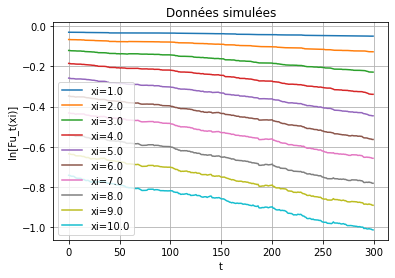

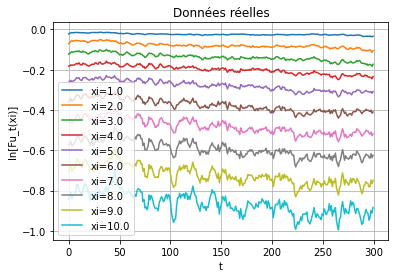

In [17]:
draw_log_log(wt_sim,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw_log_log(wt_real,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles")

On obtient des droites plutôt satisfaisantes !

#### Grandes valeurs de $\xi$ :

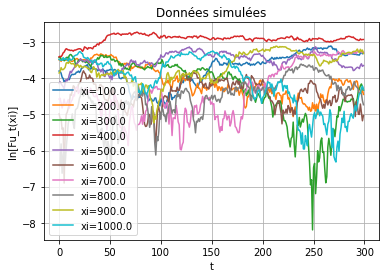

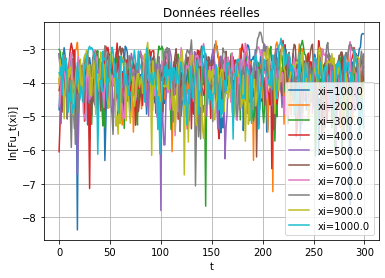

In [9]:
draw_log_log(wt_sim,ximin=100,ximax=1000,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw_log_log(wt_real,ximin=100,ximax=1000,nbreaks_xi=10,tmax=300,titre="Données réelles")

Les résultats ne sont plus du tout satisfaisants, même pour les données  simulées.

### Données normalisées

#### Petites valeurs de $\xi$ :

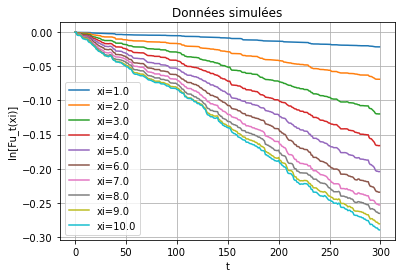

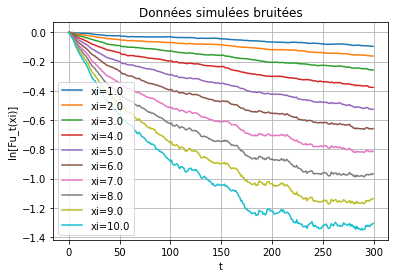

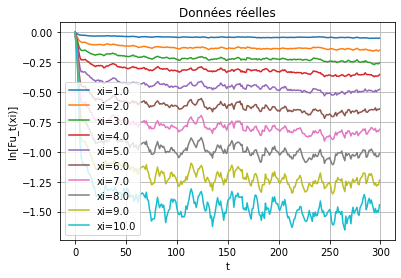

In [18]:
wt_sim_norm=normalise(wt_sim)
wt_sim_nnorm=normalise(wt_sim_noise)
wt_real_norm=normalise(wt_real)

draw_log_log(wt_sim_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw_log_log(wt_sim_nnorm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées bruitées")
draw_log_log(wt_real_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles")

#### Grandes valeurs de $\xi$ :

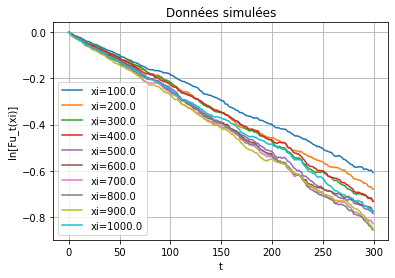

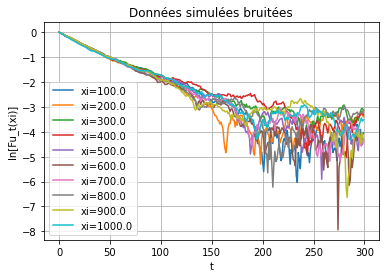

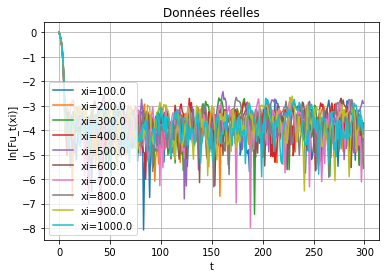

In [19]:
draw_log_log(wt_sim_norm,ximin=100,ximax=1000,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw_log_log(wt_sim_nnorm,ximin=100,ximax=1000,nbreaks_xi=10,tmax=300,titre="Données simulées bruitées")
draw_log_log(wt_real_norm,ximin=100,ximax=1000,nbreaks_xi=10,tmax=300,titre="Données réelles")

Quand les données sont normalisées, les droites sont beaucoup plus crédibles (dans le cas des données simulées) : erreur dans le raisonnement ?

Quant aux données réelles, les résultats trouvés sont étranges...

### Valeur limite de la pente

Comme la transformée de Fourier tend vers 0 pour les grandes fréquences, on s'attend à ce que quand $\xi\to\infty$, la pente de $t\mapsto\ln\mathbb{E}[e^{-i\xi\ln X_t}]$ tende vers $-\lambda$. Vérifions cela...

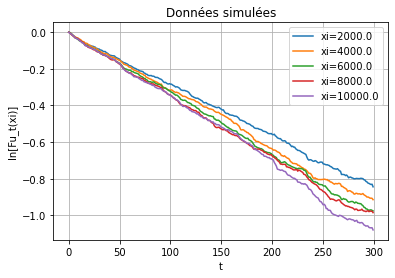

In [12]:
draw_log_log(wt_sim_norm,ximin=2000,ximax=10000,nbreaks_xi=5,tmax=300,titre="Données simulées")

On observe des droites de pentes similaires, à peu près $-1/300$. Comme une unité de temps correspond à 4 minutes, on a des droites de pente $-1/1200 min^{-1}$, qui correspondrait à une mutation toutes les $1200$ minutes. Dans la simulation, on a considéré un taux de mutation de $0,32$ par heure, soit une mutation toutes les $180$ minutes. Ça ne marche pas !

### Régression linéaire

On commence par faire des régression linéaire avec ce qui marche le mieux, à savoir les données simulées normalisées !

## Formule de la diapositive

D'après la formule indiquée sur la diapositive, la fonction $$t\mapsto \mathbb{E}[e^{-i\xi X_t}]$$ est affine (pour $\xi$ fixé). On va tracer son graphe et on s'attend à observer des droites !

### Données non normalisées

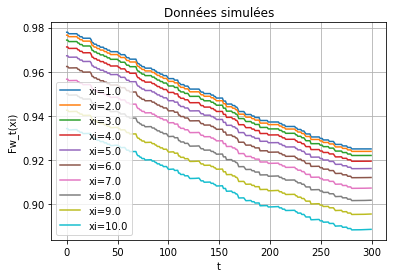

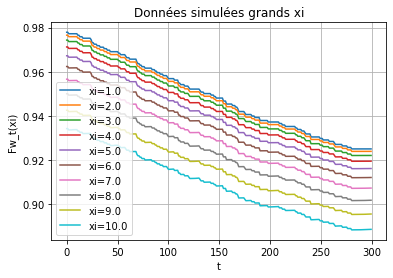

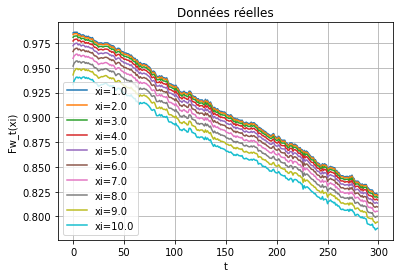

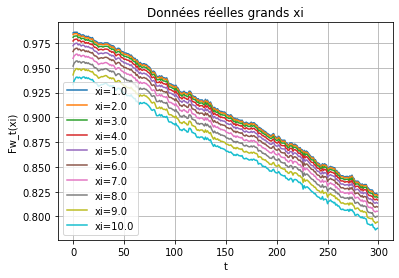

In [13]:
draw(wt_sim,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw(wt_sim,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées grands xi")
draw(wt_real,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles")
draw(wt_real,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles grands xi")

### Données normalisées

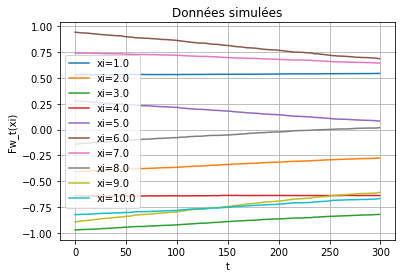

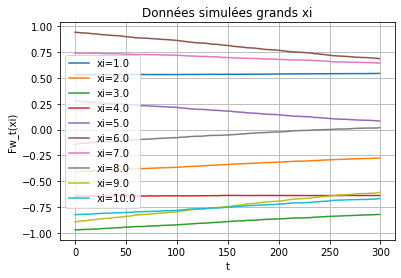

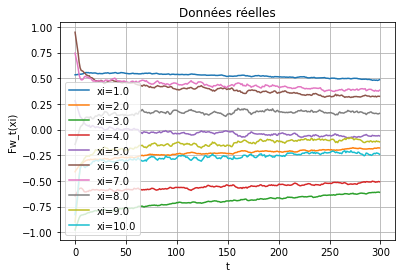

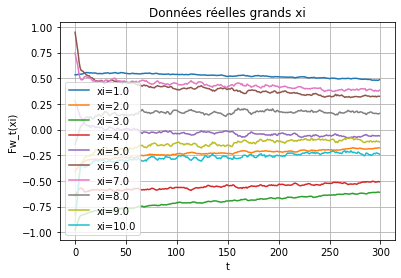

In [14]:
draw(wt_sim_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées")
draw(wt_sim_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données simulées grands xi")
draw(wt_real_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles")
draw(wt_real_norm,ximin=1,ximax=10,nbreaks_xi=10,tmax=300,titre="Données réelles grands xi")